<a href="https://colab.research.google.com/github/Nawa-Punabantu/Opt_Algos/blob/main/ParEGO_EI_SMB_tidx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install numpy==1.24.0
# !pip install scipy==1.9.0


  Using cached scipy-1.9.0.tar.gz (42.0 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [6]:
import numpy as np
print(np.__version__)
import scipy as sp
print(sp.__version__)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.optimize import differential_evolution

import matplotlib.pyplot as plt
from scipy.stats import norm




1.24.0
1.14.1


In [43]:
# smb model
# # tips:
    # - the Error: "IndexError: index 10 is out of bounds for axis 0 with size 9"
    # may be due to a miss-match in size between the initial conditons and c, q in the ode func.
# IMPORTING LIBRARIES
###########################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
# Loading the Plotting Libraries
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# from PIL import Image
from scipy import integrate
# import plotly.graph_objects as go
import pandas as pd
import json
import os
import time
###########################################
# IMPORTING MY OWN FUNCTIONS
###########################################
# from post_pre_processing_funcs import

# INPUTS
#######################################################

# UNITS:
# All units must conform to:
# Time - s
# Lengths - cm^2
# Volumes - cm^3
# Masses - g
# Concentrations - g
# Volumetric flowrates - cm^3/s


def SMB(SMB_inputs):
    iso_type, Names, color, num_comp, nx_per_col, e, Pe_all, Bm, zone_config, L, d_col, d_in, t_index_min, n_num_cycles, Q_internal, parameter_sets = SMB_inputs[0:]

    ###################### (CALCUALTED) SECONDARY INPUTS #########################

    # Column Dimensions:
    ################################################################
    F = (1-e)/e     # Phase ratio
    t=0
    t_sets = 0
    Ncol_num = np.sum(zone_config) # Total number of columns
    L_total = L*Ncol_num # Total Lenght of all columns
    A_col = np.pi*0.25*d_col**2 # cm^2
    V_col = A_col * L # cm^3
    V_col_total = Ncol_num * V_col # cm^3
    A_in = np.pi * (d_in/2)**2 # cm^2
    alpha = A_in / A_col



    # Time Specs:
    ################################################################

    t_index = t_index_min*60 # s #

    # Notes:
    # - Cyclic Steady state typically happens only after 10 cycles (ref: https://doi.org/10.1205/026387603765444500)
    # - The system is not currently designed to account for periods of no external flow

    n_1_cycle = t_index * Ncol_num  # s How long a single cycle takes

    total_cycle_time = n_1_cycle*n_num_cycles # s

    tend = total_cycle_time # s # Final time point in ODE solver

    tend_min = tend/60

    t_span = (0, tend) # +dt)  # from t=0 to t=n

    num_of_injections = int(np.round(tend/t_index)) # number of switching periods

    # 't_start_inject_all' is a vecoter containing the times when port swithes occur for each port
    # Rows --> Different Ports
    # Cols --> Different time points
    t_start_inject_all = [[] for _ in range(Ncol_num)]  # One list for each node (including the main list)

    # Calculate start times for injections
    for k in range(num_of_injections):
        t_start_inject = k * t_index
        t_start_inject_all[0].append(t_start_inject)  # Main list
        for node in range(1, Ncol_num):
            t_start_inject_all[node].append(t_start_inject + node * 0)  # all rows in t_start_inject_all are identical

    t_schedule = t_start_inject_all[0]

    # REQUIRED FUNCTIONS:
    ################################################################

    # 1.
    # Func to Generate Indices for the columns
    # def generate_repeated_numbers(n, m):
    #     result = []
    #     n = int(n)
    #     m = int(m)
    #     for i in range(m):
    #         result.extend([i] * n)
    #     return result

    # 3.
    # Func to divide the column into nodes

    # DOES NOT INCLUDE THE C0 NODE (BY DEFAULT)
    def set_x(L, Ncol_num,nx_col,dx):
        if nx_col == None:
            x = np.arange(0, L+dx, dx)
            nnx = len(x)
            nnx_col = int(np.round(nnx/Ncol_num))
            nx_BC = Ncol_num - 1 # Number of Nodes (mixing points/boundary conditions) in between columns

            # Indecies belonging to the mixing points between columns are stored in 'start'
            # These can be thought of as the locations of the nx_BC nodes.
            return x, dx, nnx_col,  nnx, nx_BC

        elif dx == None:
            nx = Ncol_num * nx_col
            nx_BC = Ncol_num - 1 # Number of Nodes in between columns
            x = np.linspace(0,L_total,nx)
            ddx = x[1] - x[0]

            # Indecies belonging to the mixing points between columns are stored in 'start'
            # These can be thought of as the locations of the nx_BC nodes.

            return x, ddx, nx_col, nx, nx_BC

    # 4. A func that:
    # (i) Calcualtes the internal flowrates given the external OR (ii) Visa-versa
    def set_flowrate_values(set_Q_int, set_Q_ext, Q_rec):
        if set_Q_ext is None and Q_rec is None:  # Chosen to specify internal/zone flowrates
            Q_I = set_Q_int[0]
            Q_II = set_Q_int[1]
            Q_III = set_Q_int[2]
            Q_IV = set_Q_int[3]

            QX = -(Q_I - Q_II)
            QF = Q_III - Q_II
            QR = -(Q_III - Q_IV)
            QD = -(QF + QX + QR) # OR: Q_I - Q_IV

            Q_ext = np.array([QF, QR, QD, QX]) # cm^3/s

            return Q_ext

        elif set_Q_int is None and Q_rec is not None:  # Chosen to specify external flowrates
            QF = set_Q_ext[0]
            QR = set_Q_ext[1]
            QD = set_Q_ext[2]
            QX = set_Q_ext[3]

            Q_I = Q_rec  # m^3/s
            Q_III = (QX + QF) + Q_I
            Q_IV = (QD - QX) + Q_I  # Fixed Q_II to Q_I as the variable was not defined yet
            Q_II = (QR - QX) + Q_IV
            Q_internal = np.array([Q_I, Q_II, Q_III, Q_IV])
            return Q_internal


    # 5. Function to Build Port Schedules:

    # This is done in two functions: (i) repeat_array and (ii) build_matrix_from_vector
    # (i) repeat_array
    # Summary: Creates the schedule for the 1st port, port 0, only. This is the port boadering Z2 & Z3 and always starts as a Feed port at t=0
    # (i) build_matrix_from_vector
    # Summary: Takes the output from "repeat_array" and creates schedules for all other ports.
    # The "trick" is that the states of each of the, n, ports at t=0, is equal to the first, n, states of port 0.
    # Once we know the states for each port at t=0, we form a loop that adds the next state.

    # 5.1
    def position_maker(schedule_quantity_name, F, R, D, X, Z_config):

        """

        Function that initializes the starting schedueles for a given quantitiy at all positions

        F, R, D and X are the values of the quantiity at the respective feed ports

        """
        # Initialize:
        X_j = np.zeros(Ncol_num)


        # We set each port in the appropriate position, depending on the nuber of col b/n Zones:
        # By default, Position i = 0 (entrance to col,0) is reserved for the feed node.

        # Initialize Positions:
        # Q_position is a vector whose len is = number of mixing points (ports) b/n columns

        X_j[0] = F        # FEED
        X_j[Z_config[2]] = R     # RAFFINATE
        X_j[Z_config[2] + Z_config[3]] = D    # DESORBENT
        X_j[Z_config[2] + Z_config[3]+  Z_config[0]] = X   # EXTRACT

        return X_j

    # 5.2
    def repeat_array(vector, start_time_num):
        # vector = the states of all ports at t=0, vector[0] = is always the Feed port
        # start_time_num = The number of times the state changes == num of port switches == num_injections
        repeated_array = np.tile(vector, (start_time_num // len(vector) + 1))
        return repeated_array[:start_time_num]

    def initial_u_col(Zconfig, Qint):
        """
        Fun that returns the the inital state at t=0 of the volumetric
        flows in all the columns.

        """
        # First row is for col0, which is the feed to zone 3
        Zconfig_roll = np.roll(Zconfig, -2)
        Qint_roll = np.roll(Qint, -2)

        # print(Qint)
        X = np.array([])

        for i in range(len(Qint_roll)):
            X_add = np.ones(Zconfig_roll[i])*Qint_roll[i]
            # print('X_add:\n', X_add)

            X = np.append(X, X_add)
        # X = np.concatenate(X)
        # print('X:\n', X)
        return X


    def build_matrix_from_vector(vector, t_schedule):
        """
        Fun that returns the schedeule given the inital state at t=0
        vector: inital state of given quantity at t=0 at all nodes
        t_schedule: times at which port changes happen

        """
        # vector = the states of all ports at t=0, vector[0] = is always the Feed port
        start_time_num = int(len(t_schedule))
        vector = np.array(vector)  # Convert the vector to a NumPy array
        n = len(vector) # number of ports/columns

        # Initialize the matrix for repeated elements, ''ALL''
        ALL = np.zeros((n, start_time_num), dtype=vector.dtype)  # Shape is (n, start_time_num)

        for i in range(start_time_num):
            # print('i:',i)
            ALL[:, i] = np.roll(vector, i)
        return ALL



    # # Uncomment as necessary depending on specification of either:
    # # (1) Internal OR (2) External flowrates :
    # # (1)
    Q_internal = np.array([Q_I, Q_II, Q_III, Q_IV])
    Q_external = set_flowrate_values(Q_internal, None, None) # Order: QF, QR, QD, QX
    QF, QR, QD, QX = Q_external[0], Q_external[1], Q_external[2], Q_external[3]
    # print('Q_external:', Q_external)

    # (2)
    # QX, QF, QR = -0.277, 0.315, -0.231  # cm^3/s
    # QD = - (QF + QX + QR)
    # Q_external = np.array([QF, QR, QD, QX])
    # Q_rec = 33.69 # cm^3/s
    # Q_internal = set_flowrate_values(None, Q_external, Q_rec) # Order: QF, QR, QD, Q

    ################################################################################################


    # Make concentration schedules for each component

    Cj_pulse_all = [[] for _ in range(num_comp)]
    for i in range(num_comp):
        Cj_position = []
        Cj_position = position_maker('Feed Conc Schedule:', parameter_sets[i]['C_feed'], 0, 0, 0, zone_config)
        Cj_pulse = build_matrix_from_vector(Cj_position,  t_schedule)
        Cj_pulse_all[i] = Cj_pulse


    Q_position = position_maker('Vol Flow Schedule:', Q_external[0], Q_external[1], Q_external[2], Q_external[3], zone_config)
    Q_pulse_all = build_matrix_from_vector(Q_position,  t_schedule)

    # Spacial Discretization:
    # Info:
    # nx --> Total Number of Nodes (EXCLUDING mixing points b/n nodes)
    # nx_col --> Number of nodes in 1 column
    # nx_BC --> Number of mixing points b/n nodes
    x, dx, nx_col, nx, nx_BC = set_x(L=L_total, Ncol_num = Ncol_num, nx_col = nx_per_col, dx = None)
    start = [i*nx_col for i in range(0,Ncol_num)] # Locations of the BC indecies
    u_col_at_t0 = initial_u_col(zone_config, Q_internal)
    Q_col_all = build_matrix_from_vector(u_col_at_t0, t_schedule)


    # DISPLAYING INPUT INFORMATION:
    # print('---------------------------------------------------')
    # print('Number of Components:', num_comp)
    # print('---------------------------------------------------')
    # print('\nTime Specs:\n')
    # print('---------------------------------------------------')
    # print('Number of Cycles:', n_num_cycles)
    # print('Time Per Cycle:', n_1_cycle/60, "min")
    # print('Simulation Time:', tend_min, 'min')
    # print('Index Time:', t_index, 's OR', t_index/60, 'min' )
    # print('Number of Port Switches:', num_of_injections)
    # print('Injections happen at t(s) = :', t_schedule, 'seconds')
    # print('---------------------------------------------------')
    # print('\nColumn Specs:\n')
    # print('---------------------------------------------------')
    # print('Configuration:', zone_config, '[Z1,Z2,Z3,Z4]')
    # print(f"Number of Columns: {Ncol_num}")
    # print('Column Length:', L, 'cm')
    # print('Column Diameter:', d_col, 'cm')
    # print('Column Volume:', V_col, 'cm^3')
    # print("alpha:", alpha, '(alpha = A_in / A_col)')
    # print("Nodes per Column:",nx_col)
    # print("Boundary Nodes locations,x[i], i =", start)
    # print("Total Number of Nodes (nx):",nx)
    # print('---------------------------------------------------')
    # print('\nFlowrate Specs:\n')
    # print('---------------------------------------------------')
    # print("External Flowrates =", Q_external, '[F,R,D,X] ml/min')
    # print("Ineternal Flowrates =", Q_internal, 'ml/min')
    # print('---------------------------------------------------')
    # print('\nPort Schedules:')
    # for i in range(num_comp):
    #     print(f"Concentration Schedule:\nShape:\n {Names[i]}:\n",np.shape(Cj_pulse_all[i]),'\n', Cj_pulse_all[i], "\n")
    # print("Injection Flowrate Schedule:\nShape:",np.shape(Q_pulse_all),'\n', Q_pulse_all, "\n")
    # print("Respective Column Flowrate Schedule:\nShape:",np.shape(Q_col_all),'\n', Q_col_all, "\n")



    # ###########################################################################################

    # Isotherm Models:


    ###########################################################################################

    # 1. LINEAR
    def iso_lin(theta_lin, c):
        # params: [HA, HB]
        H = theta_lin
        q_star = H*c

        return q_star # [qA, qB, ...]

    # 2.  LANGMUIR

    # 2.1 Independent Langmuir
    def iso_langmuir(theta_lang, c, comp_idx): # already for specific comp
        H = theta_lang
        q_star = H*c/(1 + H*c)
        #q_star = H[comp_idx]*c/(1 + K[0]*c + K[1]*c)
        # q_star = theta_lang[0]*c/(1 + theta_lang[1]*c + theta_lang[2]*c) +\
        #     theta_lang[3]*c/(1 + theta_lang[4]*c + theta_lang[5]*c)
        return q_star

    # 2.3 Coupled Langmuir
    def iso_cup_langmuir(theta_cuplang, c, IDX, comp_idx): # already for specific comp
        H = theta_cuplang[:2] # [HA, HB]
        K = theta_cuplang[2:] # [KA, KB]
        cA = c[IDX[0] + 0: IDX[0] + nx ]
        cB = c[IDX[1] + 0: IDX[1] + nx ]
        c_i = [cA, cB]
        q_star = H[comp_idx]*c_i[comp_idx]/(1 + K[0]*cA + K[1]*cB)
        return q_star

    # 2.3 Bi-Langmuir
    def iso_bi_langmuir(theta_bl, c, IDX, comp_idx): # already for specific comp
        cA = c[IDX[0] + 0: IDX[0] + nx ]
        cB = c[IDX[1] + 0: IDX[1] + nx ]
        c_i = [cA, cB]

        q_star = theta_bl[0]*c_i[comp_idx]/(1 + theta_bl[1]*cA + theta_bl[2]*cB) +\
                theta_bl[3]*c_i[comp_idx]/(1 + theta_bl[4]*cA + theta_bl[5]*cB)

        return q_star


    # 3. FREUDLICH:
    def iso_freundlich(theta_fre, c): # already for specific comp
        q_star = theta_fre[0]*c**(1/theta_fre[1])
        return q_star





    ###########################################################################################

    ###########################################################################################

    # Mass Transfer (MT) Models:

    def mass_transfer(kav_params, q_star, q): # already for specific comp
        # kav_params: [kA, kB]
        kav =  kav_params
        MT = kav * Bm/(5 + Bm) * (q_star - q)
        # MT = kav * (q_star - q)
        return MT

    # MT PARAMETERS
    ###########################################################################################
    # print('np.shape(parameter_sets[:]["kh"]):', np.shape(parameter_sets[3]))
    kav_params = [parameter_sets[i]["kh"] for i in range(num_comp)]  # [kA, kB, kC, kD, kE, kF]
    print('kav_params:', kav_params)
    print('----------------------------------------------------------------')
    ###########################################################################################

    # # FORMING THE ODES


    # Form the remaining schedule matrices that are to be searched by the funcs

    # Column velocity schedule:
    u_col_all = -Q_col_all/A_col/e

    # Column Dispersion schedule:
    # Different matrices for each comp because diff Pe's for each comp
    D_col_all = []
    for i in range(num_comp): # for each comp
        D_col = -(u_col_all*L)/Pe_all[i] # constant dispersion coeff
        D_col_all.append(D_col)

    # Storage Spaces:
    coef_0 = np.zeros_like(u_col_all)
    coef_1 = np.zeros_like(u_col_all)
    coef_2 = np.zeros_like(u_col_all)

    # coef_0, coef_1, & coef_2 correspond to the coefficents of ci-1, ci & ci+1 respectively
    # These depend on u and so change with time, thus have a schedule

    # From descritization:
    coef_0_all = []
    coef_1_all = []
    coef_2_all = []
    for j in range(num_comp): # for each comp
        for i  in range(Ncol_num): # coefficients for each col
            coef_0[i,:] = ( D_col_all[j][i,:]/dx**2 ) - ( u_col_all[i,:]/dx ) # coefficeint of i-1
            coef_1[i,:] = ( u_col_all[i,:]/dx ) - (2*D_col_all[j][i,:]/(dx**2))# coefficeint of i
            coef_2[i,:] = (D_col_all[j][i,:]/(dx**2))    # coefficeint of i+1
        coef_0_all.append(coef_0)
        coef_1_all.append(coef_1)
        coef_2_all.append(coef_2)

    # All shedules:
    # For each shceudle, rows => col idx, columns => Time idx
    # :
    # - Q_pulse_all: Injection flowrates
    # - C_pulse_all: Injection concentrations for each component
    # - Q_col_all:  Flowrates WITHIN each col
    # - u_col_all: Linear velocities WITHIN each col
    # - D_col_all: Dispersion coefficeints WITHIN each col
    # - coef_0, 1 and 2: ci, ci-1 & ci+1 ceofficients

    # print('coef_0:\n',coef_0)
    # print('coef_1:\n',coef_1)
    # print('coef_2:\n',coef_2)
    # print('\nD_col_all:\n',D_col_all)
    # print('Q_col_all:\n',Q_col_all)
    # print('A_col:\n',A_col)
    # print('u_col_all:\n',u_col_all)


    def coeff_matrix_builder_UNC(t, Q_col_all, Q_pulse_all, dx, start, alpha, c, nx_col, comp_idx): # note that c_length must include nx_BC

        # Define the functions that call the appropriate schedule matrices:
        # Because all scheudels are of the same from, only one function is required
        # Calling volumetric flows:
        get_X = lambda t, X_schedule, col_idx: next((X_schedule[col_idx][j] for j in range(len(X_schedule[col_idx])) if t_start_inject_all[col_idx][j] <= t < t_start_inject_all[col_idx][j] + t_index), 1/100000000)
        get_C = lambda t, C_schedule, col_idx, comp_idx: next((C_schedule[comp_idx][col_idx][j] for j in range(len(C_schedule[comp_idx][col_idx])) if t_start_inject_all[col_idx][j] <= t < t_start_inject_all[col_idx][j] + t_index), 1/100000000)

        def small_col_matix(nx_col, col_idx):
        # Initialize small_col_coeff ('small' = for 1 col)

            small_col_coeff = np.zeros((int(nx_col),int(nx_col))) #(5,5)

            # Where the 1st (0th) row and col are for c1
            # get_C(t, coef_0_all, k, comp_idx)
            # small_col_coeff[0,0], small_col_coeff[0,1] = get_X(t,coef_1,col_idx), get_X(t,coef_2,col_idx)
            small_col_coeff[0,0], small_col_coeff[0,1] = get_C(t,coef_1_all,col_idx, comp_idx), get_C(t,coef_2_all,col_idx, comp_idx)
            # for c2:
            # small_col_coeff[1,0], small_col_coeff[1,1], small_col_coeff[1,2] = get_X(t,coef_0,col_idx), get_X(t,coef_1,col_idx), get_X(t,coef_2,col_idx)
            small_col_coeff[1,0], small_col_coeff[1,1], small_col_coeff[1,2] = get_C(t,coef_0_all,col_idx, comp_idx), get_C(t, coef_1_all, col_idx, comp_idx), get_C(t, coef_2_all,col_idx, comp_idx)

            for i in range(2,nx_col): # from row i=2 onwards
                # np.roll the row entries from the previous row, for all the next rows
                new_row = np.roll(small_col_coeff[i-1,:],1)
                small_col_coeff[i:] = new_row

            small_col_coeff[-1,0] = 0
            small_col_coeff[-1,-1] = small_col_coeff[-1,-1] +  get_C(t,coef_2_all,col_idx, comp_idx) # coef_1 + coef_2 account for rolling boundary


            return small_col_coeff


        larger_coeff_matrix = np.zeros((nx,nx)) # ''large'' = for all cols # (20, 20)

        # Add the cols
        for col_idx in range(Ncol_num):
            larger_coeff_matrix[col_idx*nx_col:(col_idx+1)*nx_col, col_idx*nx_col:(col_idx+1)*nx_col] = small_col_matix(nx_col,col_idx)
        # print('np.shape(larger_coeff_matrix)\n',np.shape(larger_coeff_matrix))

        # vector_add: vector that applies the boundary conditions to each boundary node
        def vector_add(nx, c, start, comp_idx):
            vec_add = np.zeros(nx)
            c_BC = np.zeros(Ncol_num)
            # Indeceis for the boundary nodes are stored in "start"
            # Each boundary node is affected by the form:
            # c_BC = V1 * C_IN - V2 * c[i] + V3 * c[i+1]

            # R1 = ((beta * alpha) / gamma)
            # R2 = ((2 * Da / (u * dx)) / gamma)
            # R3 = ((Da / (2 * u * dx)) / gamma)

            # Where:
            # C_IN is the weighted conc exiting the port facing the column entrance.
            # alpha , bata and gamma depend on the column vecolity and are thus time dependant
            # Instead of forming schedules for alpha , bata and gamma, we calculate them in-line

            for i in range(len(start)):
                #  start[i] => the node at the entrance to the ith col
                # So start[3] is the node representing the 1st node in col 3

                Q_1 = get_X(t, Q_col_all, i-1) # Vol_flow from previous column (which for column 0, is the last column in the chain)
                Q_2 = get_X(t, Q_pulse_all, i) # Vol_flow injected IN port i

                Q_out_port = get_X(t, Q_col_all, i) # Vol_flow OUT of port 0 (Also could have used Q_1 + Q_2)


                W1 = Q_1/Q_out_port # Weighted flowrate to column i
                W2 = Q_2/Q_out_port # Weighted flowrate to column i

                # Calcualte Weighted Concentration:

                c_injection = get_C(t, Cj_pulse_all, i, comp_idx)

                if Q_2 > 0: # Concentration in the next column is only affected for injection flows IN
                    C_IN = W1 * c[i*nx_col-1] + W2 * c_injection
                else:
                    # C_IN = c[i*nx_col-1] # no change in conc during product collection
                    C_IN = c[start[i]-1] # no change in conc during product collection

                # Calcualte alpha, bata and gamma:
                # Da = get_X(t, D_col_all, i)
                Da = get_C(t, D_col_all, i, comp_idx)
                u =  get_X(t, u_col_all, i)
                beta = 1 / alpha
                gamma = 1 - 3 * Da / (2 * u * dx)

                ##
                R1 = ((beta * alpha) / gamma)
                R2 = ((2 * Da / (u * dx)) / gamma)
                R3 = ((Da / (2 * u * dx)) / gamma)
                ##

                # Calcualte the BC effects:
                j = start[i]
                c_BC[i] = R1 * C_IN - R2 * c[j] + R3 * c[j+1] # the boundary concentration for that node

            # print('c_BC:\n', c_BC)

            for k in range(len(c_BC)):
                # vec_add[start[k]]  = get_X(t,coef_0,k)*c_BC[k]
                vec_add[start[k]]  = get_C(t, coef_0_all, k, comp_idx)*c_BC[k]

            return vec_add
            # print('np.shape(vect_add)\n',np.shape(vec_add(nx, c, start)))
        return larger_coeff_matrix, vector_add(nx, c, start, comp_idx)

    def coeff_matrix_builder_CUP(t, Q_col_all, Q_pulse_all, dx, start_CUP, alpha, c, nx_col,IDX): # note that c_length must include nx_BC

        # Define the functions that call the appropriate schedule matrices:
        # Because all scheudels are of the same from, only one function is required
        # Calling volumetric flows:
        get_X = lambda t, X_schedule, col_idx: next((X_schedule[col_idx][j] for j in range(len(X_schedule[col_idx])) if t_start_inject_all[col_idx][j] <= t < t_start_inject_all[col_idx][j] + t_index), 1/100000000)


        # 1. From coefficent "small" matrix for movement of single comp through single col
        # 2. Form  "large" coefficent matrix for movement through one all cols
        # 3. The large  coefficent matrix for each comp will then be combined into Final Matrix

        # 1.
        def small_col_matrix(nx_col, col_idx):

        # Initialize small_col_coeff ('small' = for 1 col)

            small_col_coeff = np.zeros((int(nx_col),int(nx_col))) #(5,5)

            # Where the 1st (0th) row and col are for c1
            #
            small_col_coeff[0,0], small_col_coeff[0,1] = get_X(t,coef_1,col_idx), get_X(t,coef_2,col_idx)
            # for c2:
            small_col_coeff[1,0], small_col_coeff[1,1], small_col_coeff[1,2] = get_X(t,coef_0,col_idx), get_X(t,coef_1,col_idx), get_X(t,coef_2,col_idx)

            for i in range(2,nx_col): # from row i=2 onwards
                # np.roll the row entries from the previous row, for all the next rows
                new_row = np.roll(small_col_coeff[i-1,:],1)
                small_col_coeff[i:] = new_row

            small_col_coeff[-1,0] = 0
            small_col_coeff[-1,-1] = small_col_coeff[-1,-1] +  get_X(t,coef_2,col_idx) # coef_1 + coef_2 account for rolling boundary

            return small_col_coeff

        # 2. Func to Build Large Matrix

        def matrix_builder(M, M0):
            # M = Matrix to add (small)
            # M0 = Initial state of the larger matrix to be added to
            nx_col = M.shape[0]
            repeat = int(np.round(M0.shape[0]/M.shape[0]))# numbner of times the small is added to the larger matrix
            for col_idx in range(repeat):
                        M0[col_idx*nx_col:(col_idx+1)*nx_col, col_idx*nx_col:(col_idx+1)*nx_col] = M
            return M0


        # 3. Generate and Store the Large Matrices
        # Storage Space:
        # NOTE: Assuming all components have the same Dispersion coefficients,
        # all components will have the same large_col_matrix
        # Add the cols
        larger_coeff_matrix = np.zeros((nx,nx)) # ''large'' = for all cols # (20, 20)

        for col_idx in range(Ncol_num):
            larger_coeff_matrix[col_idx*nx_col:(col_idx+1)*nx_col, col_idx*nx_col:(col_idx+1)*nx_col] = small_col_matrix(nx_col,col_idx)

        # print('np.shape(larger_coeff_matrix)\n',np.shape(larger_coeff_matrix))

        # Inital final matrix:
        n = nx*num_comp
        final_matrix0 = np.zeros((n,n))


        final_matrix = matrix_builder(larger_coeff_matrix, final_matrix0)

            # vector_add: vector that applies the boundary conditions to each boundary node
        def vector_add(nx, c, start):
            vec_add = np.zeros(nx*num_comp)
            c_BC = np.zeros(nx*num_comp)
            # Indeceis for the boundary nodes are stored in "start"
            # Each boundary node is affected by the form:
            # c_BC = V1 * C_IN - V2 * c[i] + V3 * c[i+1]

            # R1 = ((beta * alpha) / gamma)
            # R2 = ((2 * Da / (u * dx)) / gamma)
            # R3 = ((Da / (2 * u * dx)) / gamma)

            # Where:
            # C_IN is the weighted conc exiting the port facing the column entrance.
            # alpha , bata and gamma depend on the column vecolity and are thus time dependant
            # Instead of forming schedules for alpha , bata and gamma, we calculate them in-line

            for i in range(len(start)):
                #k = i%len(start) # Recounts columns for B
                Q_1 = get_X(t, Q_col_all, i-1) # Vol_flow from previous column (which for column 0, is the last column in the chain)
                Q_2 = get_X(t, Q_pulse_all, i) # Vol_flow injected IN port i

                Q_out_port = get_X(t, Q_col_all, i) # Vol_flow OUT of port 0 (Also could have used Q_1 + Q_2)


                W1 = Q_1/Q_out_port # Weighted flowrate to column i
                W2 = Q_2/Q_out_port # Weighted flowrate to column i

                # Calcualte Weighted Concentration:
                # Identifiers:
                A = IDX[0]
                B = IDX[1]

                # C_IN_A = W1 * c[A + i*nx_col-1] + W2 * get_X(t, C_pulse_all_A, i) # c[-1] conc out the last col
                # C_IN_B = W1 * c[B + i*nx_col-1] + W2 * get_X(t, C_pulse_all_B, i) # c[-1] conc out the last col

                C_IN_A = W1 * c[A + i*nx_col-1] + W2 * get_X(t, Cj_pulse_all[0], i) # c[-1] conc out the last col
                C_IN_B = W1 * c[B + i*nx_col-1] + W2 * get_X(t, Cj_pulse_all[1], i) # c[-1] conc out the last col


                # Calcualte alpha, bata and gamma:
                Da = get_X(t, D_col_all, i)
                u =  get_X(t, u_col_all, i)
                beta = 1 / alpha
                gamma = 1 - 3 * Da / (2 * u * dx)

                ##
                R1 = ((beta * alpha) / gamma)
                R2 = ((2 * Da / (u * dx)) / gamma)
                R3 = ((Da / (2 * u * dx)) / gamma)
                ##

                # Calcualte the BC effects:
                j = start[i]
                # print('j:', j)
                c_BC[i] = R1 * C_IN_A - R2 * c[j] + R3 * c[j+1] # the boundary concentration for that node
                c_BC[B + i] = R1 * C_IN_B - R2 * c[B+j] + R3 * c[B+j+1]
            # print('c_BC:\n', c_BC)
            # print('c_BC.shape:\n', c_BC.shape)

            for k in range(len(start)):
                vec_add[start[k]]  = get_X(t,coef_0,k)*c_BC[k]
                vec_add[B + start[k]]  = get_X(t,coef_0,k)*c_BC[B+ k]

            return vec_add
            # print('np.shape(vect_add)\n',np.shape(vec_add(nx, c, start)))
        return final_matrix, vector_add(nx, c, start_CUP)

    # ###########################################################################################

    # # mod1: UNCOUPLED ISOTHERM:
    # # Profiles for each component can be solved independently

    # ###########################################################################################
    def mod1(t, v, comp_idx, Q_pulse_all):
        # call.append("call")
        # print(len(call))
        c = v[:nx]
        q = v[nx:]

        # Initialize the derivatives
        dc_dt = np.zeros_like(c)
        dq_dt = np.zeros_like(q)
        # print('v size\n',np.shape(v))

        # Isotherm:
        #########################################################################
        isotherm = iso_lin(theta_lin[comp_idx], c)
        #isotherm = iso_langmuir(theta_lang[comp_idx], c, comp_idx)
        #isotherm = iso_freundlich(theta_fre, c)


        # Mass Transfer:
        #########################################################################
        # print('isotherm size\n',np.shape(isotherm))
        MT = mass_transfer(kav_params[comp_idx], isotherm, q)
        #print('MT:\n', MT)

        coeff_matrix, vec_add = coeff_matrix_builder_UNC(t, Q_col_all, Q_pulse_all, dx, start, alpha, c, nx_col, comp_idx)
        # print('coeff_matrix:\n',coeff_matrix)
        # print('vec_add:\n',vec_add)
        dc_dt = coeff_matrix @ c + vec_add - F * MT
        dq_dt = MT

        return np.concatenate([dc_dt, dq_dt])

    # ##################################################################################

    def mod2(t, v):

        # where, v = [c, q]
        c = v[:num_comp*nx] # c = [cA, cB] | cA = c[:nx], cB = c[nx:]
        q = v[num_comp*nx:] # q = [qA, qB]| qA = q[:nx], qB = q[nx:]

        # Craate Lables so that we know the component assignement in the c vecotor:
        A, B = 0*nx, 1*nx # Assume Binary 2*nx, 3*nx, 4*nx, 5*nx
        IDX = [A, B]

        # Thus to refer to the liquid concentration of the i = nth row of component B: c[C + n]
        # Or the the solid concentration 10th row of component B: q[B + 10]
        # Or to refer to all A's OR B's liquid concentrations: c[A + 0: A + nx] OR c[B + 0: B + nx]


        # Initialize the derivatives
        dc_dt = np.zeros_like(c)
        dq_dt = np.zeros_like(q)


        coeff_matrix, vec_add = coeff_matrix_builder_CUP(t, Q_col_all, Q_pulse_all, dx, start, alpha, c, nx_col, IDX)
        # print('coeff_matrix:\n',coeff_matrix)
        # print('vec_add:\n',vec_add)



        ####################### Building MT Terms ####################################################################

        # Initialize

        MT = np.zeros(len(c)) # column vector: MT kinetcis for each comp: MT = [MT_A MT_B]

        for comp_idx in range(num_comp): # for each component

            ######################(i) Isotherm ####################################################################

            # Comment as necessary for required isotherm:
            # isotherm = iso_bi_langmuir(theta_blang[comp_idx], c, IDX, comp_idx)
            isotherm = iso_cup_langmuir(theta_cup_lang, c, IDX, comp_idx)
            # print('qstar:\n', isotherm.shape)
            ################### (ii) MT ##########################################################
            MT_comp = mass_transfer(kav_params[comp_idx], isotherm, q[IDX[comp_idx] + 0: IDX[comp_idx] + nx ])
            MT[IDX[comp_idx] + 0: IDX[comp_idx] + nx ] = MT_comp
            # [MT_A, MT_B, . . . ] KINETICS FOR EACH COMP



        dc_dt = coeff_matrix @ c + vec_add - F * MT
        dq_dt = MT

        return np.concatenate([dc_dt, dq_dt])

    # ##################################################################################

    # SOLVING THE ODES
    # creat storage spaces:
    y_matrices = []

    t_sets = []
    t_lengths = []

    c_IN_values_all = []
    F_in_values_all = []
    call = []

    print('----------------------------------------------------------------')
    print("\n\nSolving the ODEs. . . .")



    if iso_type == "UNC": # UNCOUPLED - solve 1 comp at a time
        for comp_idx in range(num_comp): # for each component
            print(f'Solving comp {comp_idx}. . . .')
            # print('\nSolution Size:')
            v0 = np.zeros(Ncol_num* (nx_col + nx_col)) #  for both c and q
            solution = solve_ivp(mod1, t_span, v0, args=(comp_idx , Q_pulse_all))
            y_solution, t = solution.y, solution.t
            y_matrices.append(y_solution)
            t_sets.append(t)
            t_lengths.append(len(t))
            # print(f'y_matrices[{i}]', y_matrices[i].shape)


    # Assuming only a binary coupled system
    if iso_type == "CUP": # COUPLED - solve
            # nx = nx_col*num_comp
            v0 = np.zeros(num_comp*(nx)*2) # for c and 2, for each comp
            solution = solve_ivp(mod2, t_span, v0)
            y_solution, t = solution.y, solution.t
            # Convert y_solution from: [cA, cB, qA, qB] ,  TO: [[cA, qA ], [cB, qB]]
            # Write a function to do that

            def reshape_ysol(x, nx, num_comp):
                # Initialize a list to store the reshaped components
                reshaped_list = []

                # Iterate over the number of components
                for i in range(num_comp):
                    # Extract cX and qX submatrices for the i-th component
                    cX = x[i*nx:(i+1)*nx, :]      # Extract cX submatrix
                    qX = x[i*nx + num_comp*nx : (i+1)*nx + num_comp*nx, :]       # Extract qX submatrix
                    concat = np.concatenate([cX, qX])
                    # print('i:', i)
                    # print('cX:\n',cX)
                    # print('qX:\n',qX)
                    # Append the reshaped pair [cX, qX] to the list
                    reshaped_list.append(concat)

                # Convert the list to a NumPy array
                result = np.array(reshaped_list)

                return result

            y_matrices = reshape_ysol(y_solution, nx, num_comp)
            # print('len(t_sets) = ', len(t_sets[0]))
            # print('len(t) = ', len(t))

    print('----------------------------------------------------------------')
    print('\nSolution Size:')
    for i in range(num_comp):
        print(f'y_matrices[{i}]', y_matrices[i].shape)
    print('----------------------------------------------------------------')
    print('----------------------------------------------------------------')




    # ###########################################################################################

    # VISUALIZATION

    ###########################################################################################




    # MASS BALANCE AND PURITY CURVES
    ###########################################################################################

    def find_indices(t_ode_times, t_schedule):
        """
        t_schedule -> vector of times when (events) port switches happen e.g. at [0,5,10] seconds
        t_ode_times -> vector of times from ODE

        We want to know where in t_ode_times, t_schedule occures
        These iwll be stored as indecies in t_idx
        Returns:np.ndarray: An array of indices in t_ode_times corresponding to each value in t_schedule.
        """
        t_idx = np.searchsorted(t_ode_times, t_schedule)
        t_idx = np.append(t_idx, len(t_ode_times))

        return t_idx

    # Fucntion to find the values of scheduled quantities
    # at all t_ode_times points

    def get_all_values(X, t_ode_times, t_schedule_times, Name):

        """
        X -> Matrix of Quantity at each schedule time. e.g:
        At t_schedule_times = [0,5,10] seconds feed:
        a concentraction of, X = [1,2,3] g/m^3

        """
        # Get index times
        t_idx = find_indices(t_ode_times, t_schedule_times)
        # print('t_idx:\n', t_idx)

        # Initialize:
        nrows = np.shape(X)[0]
        # print('nrows', nrows)

        values = np.zeros((nrows, len(t_ode_times))) # same num of rows, we just extend the times
        # print('np.shape(values):\n',np.shape(values))

        # Modify:
        k = 0

        for i in range(len(t_idx)-1): # during each schedule interval
            j = i%nrows

            # # k is a counter that pushes the row index to the RHS every time it loops back up
            # if j == 0 and i == 0:
            #     pass
            # elif j == 0:
            #     k += 1

            # print('j',j)

            X_new = np.tile(X[:,j], (len(t_ode_times[t_idx[i]:t_idx[i+1]]), 1))

            values[:, t_idx[i]:t_idx[i+1]] = X_new.T # apply appropriate quantity value at approprite time intrval

        # Visualize:
        # # Table
        # print(Name," Values.shape:\n", np.shape(values))
        # print(Name," Values:\n", values)
        # # Plot
        # plt.plot(t_ode_times, values)
        # plt.xlabel('Time (s)')
        # plt.ylabel('X')
        # plt.show()

        return values, t_idx


    # Function that adds row slices from a matrix M into one vector
    def get_X_row(M, row_start, jump, width):

        """
        M  => Matrix whos rows are to be searched and sliced
        row_start => Starting row - the row that the 1st slice comes from
        jump => How far the row index jumps to caputre the next slice
        width => the widths of each slice e.g. slice 1 is M[row, width[0]:width[1]]

        """
        # Quick look at the inpiuts
        # print('M.shape:\n', M.shape)
        # print('width:', width)

        # Initialize
        values = []
        nrows = M.shape[0]

        for i in range(len(width)-1):
            j = i%nrows
            # print('i', i)
            # print('j', j)
            t_start = int(width[i])
            tend = int(width[i+1])

            kk = (row_start+j*jump)%nrows

            MM = M[kk, t_start:tend]

            values.extend(MM)

        return values



    #  MASS INTO SYSMEM

    # - Only the feed port allows material to FLOW IN
    ###########################################################################################

    # Convert the Feed concentration schedule to show feed conc for all time
    # Do this for each component
    # C_feed_all = [[] for _ in range(num_comp)]

    row_start = 0 # iniital feed port row in schedule matrix

    row_start_matrix_raff = nx_col*Z3
    row_start_matrix_ext = (nx_col*(Z3 + Z4 + Z1))

    row_start_schedule_raff = row_start+Z3
    row_start_schedule_ext = row_start+Z3+Z4+Z1

    jump_schedule = 1
    jump_matrix = nx_col


    def feed_profile(t_odes, Cj_pulse_all, t_schedule, row_start, jump):

        """"
        Function that returns :
        (i) The total mass fed of each component
        (ii) Vector of feed conc profiles of each component
        """

        # Storage Locations:
        C_feed_all = []
        t_idx_all = []
        m_feed = []

        C_feed = [[] for _ in range(num_comp)]

        for i in range(num_comp):

            if iso_type == 'UNC':

                C, t_idx = get_all_values(Cj_pulse_all[i], t_odes[i], t_schedule, 'Concentration')
                t_idx_all.append(t_idx)

            elif iso_type == 'CUP':
                C, t_idx_all = get_all_values(Cj_pulse_all[i], t_odes, t_schedule, 'Concentration')

            C_feed_all.append(C)

            # print('t_idx_all:\n', t_idx_all )

        for i in range(num_comp):
            if iso_type == 'UNC':
                C_feed[i] = get_X_row( C_feed_all[i], row_start, jump, t_idx_all[i]) # g/cm^3
            elif iso_type == 'CUP':
                C_feed[i] = get_X_row( C_feed_all[i], row_start, jump, t_idx_all) # g/cm^3
        # print('C_feed[0]:',C_feed[0])

        for i in range(num_comp):
            F_feed = np.array([C_feed[i]]) * QF # (g/cm^3 * cm^3/s)  =>  g/s | mass flow into col (for comp, i)
            F_feed = np.array([F_feed]) # g/s

            if iso_type == 'UNC':
                m_feed_add = integrate.simpson(F_feed, x=t_odes[i]) # g
            if iso_type == 'CUP':
                m_feed_add = integrate.simpson(F_feed, x=t_odes) # g

            m_feed.append(m_feed_add)

        m_feed = np.concatenate(m_feed) # g
        # print(f'm_feed: {m_feed} g')

        return C_feed, m_feed, t_idx_all

    if iso_type == 'UNC':
        C_feed, m_feed, t_idx_all = feed_profile(t_sets, Cj_pulse_all, t_schedule, row_start, jump_schedule)
    elif iso_type == 'CUP':
        C_feed, m_feed, t_idx_all = feed_profile(t, Cj_pulse_all, t_schedule, row_start, jump_schedule)





    def prod_profile(t_odes, y_odes, t_schedule, row_start_matrix, jump_matrix, t_idx_all, row_start_schedule):

        """"
        Function that can be used to return:

        (i) The total mass exited at the Raffinate or Extract ports of each component
        (ii) Vector of Raffinate or Extract mass flow profiles of each component
        (iii) Vector of Raffinate or Extract vol flow profiles of each component

        P = Product either raff or ext
        """
        ######## Storages for the Raffinate #########
        C_P1 = []
        C_P2 = []

        Q_all_flows = [] # Flowrates expirenced by each component
        m_out_P = np.zeros(num_comp)

        P_vflows_1 = []
        P_mflows_1 = []
        m_P_1 = []

        P_vflows_2 = []
        P_mflows_2 = []
        m_P_2 = []
        t_idx_all_Q = []

        P_mprofile = []
        P_cprofile = []
        P_vflow = [[] for _ in range(num_comp)]


        if iso_type == 'UNC':
            for i in range(num_comp): # for each component
                Q_all_flows_add, b = get_all_values(Q_col_all, t_odes[i], t_schedule, 'Column Flowrates')
                # print('Q_all_flows_add:\n', Q_all_flows_add)
                Q_all_flows.append(Q_all_flows_add) # cm^3/s
                t_idx_all_Q.append(b)

        elif iso_type == 'CUP':
            Q_all_flows, t_idx_all_Q = get_all_values(Q_col_all, t_odes, t_schedule, 'Column Flowrates')



        for i in range(num_comp):# for each component

            # Search the ODE matrix
            C_R1_add = np.array(get_X_row( y_odes[i][:nx,:], row_start_matrix-1, jump_matrix, t_idx_all[i])) # exclude q
            C_R2_add = np.array(get_X_row( y_odes[i][:nx,:], row_start_matrix, jump_matrix, t_idx_all[i]))
            # Search the Flowrate Schedule
            P_vflows_1_add = np.array(get_X_row(Q_all_flows[i], row_start_schedule-1, jump_schedule, t_idx_all_Q[i]))
            P_vflows_2_add = np.array(get_X_row(Q_all_flows[i], row_start_schedule, jump_schedule, t_idx_all_Q[i]))

            # Raffinate Massflow Curves
            # print('C_R1_add.type():\n',type(C_R1_add))
            # print('np.shape(C_R1_add):\n', np.shape(C_R1_add))

            # print('P_vflows_1_add.type():\n',type(P_vflows_1_add))
            # print('np.shape(P_vflows_1_add):\n', np.shape(P_vflows_1_add))

            # Assuming only conc change accross port when (i) adding feed or (ii) desorbent
            C_R2_add = C_R1_add
            # P_mflows_1_add = C_R1_add * P_vflows_1_add  # (g/cm^3 * cm^3/s)  =>  g/s
            # P_mflows_2_add = C_R2_add * P_vflows_2_add  # g/s

            if row_start_matrix == row_start_matrix_raff:
                P_vflows_1_add = -QR*np.ones_like(C_R1_add)
                P_mflows_1_add = C_R1_add * P_vflows_1_add  # (g/cm^3 * cm^3/s)  =>  g/s

            elif row_start_matrix == row_start_matrix_ext:
                P_vflows_1_add = -QX*np.ones_like(C_R1_add)
                P_mflows_1_add = C_R1_add * P_vflows_1_add  # (g/cm^3 * cm^3/s)  =>  g/s




            # Flow profiles:
            # Concentration
            P_cprofile.append(C_R1_add) # g/s
            # Mass g/s
            P_mprofile.append(P_mflows_1_add ) #- P_mflows_2_add) # g/s
            # Volumetric cm^3/s
            P_vflow[i] = P_vflows_1_add #- P_vflows_2_add # cm^3

            # Integrate
            if iso_type == 'UNC':
                m_P_add_1 = integrate.simpson(P_mflows_1_add, x=t_odes[i]) # g
                # m_P_add_2 = integrate.simpson(P_mflows_2_add, x=t_odes[i]) # g

            if iso_type == 'CUP':
                m_P_add_1 = integrate.simpson(P_mflows_1_add, x=t_odes) # g
                # m_P_add_2 = integrate.simpson(P_mflows_2_add, x=t_odes) # g



            # Storage
            C_P1.append(C_R1_add)  # Concentration Profiles
            C_P2.append(C_R2_add)

            P_vflows_1.append(P_vflows_1_add)
            P_vflows_2.append(P_vflows_2_add)

            P_mflows_1.append(P_mflows_1_add)
            # P_mflows_2.append(P_mflows_2_add)

            m_P_1.append(m_P_add_1) # masses of each component
            # m_P_2.append(m_P_add_2) # masses of each component

        # Final Mass Exited
        # Mass out from P and ext
        for i in range(num_comp):
            m_out_P_add = m_P_1[i] #- m_P_2[i]
            # print(f'i:{i}')
            # print(f'm_out_P_add = m_P_1[i] - m_P_2[i]: { m_P_1[i]} - {m_P_2[i]}')
            m_out_P[i] = m_out_P_add # [A, B] g

        return P_cprofile, P_mprofile, m_out_P, P_vflow



    # Evaluating the product flowrates
    #######################################################
    # raff_mprofile, m_out_raff, raff_vflow = prod_profile(t_sets, y_matrices, t_schedule, row_start_R1, row_start_R2, jump_matrix, t_idx_all, row_start+Z3)
    # ext_mprofile, m_out_ext, ext_vflow = prod_profile(t_sets, y_matrices, t_schedule, row_start_X1, row_start_X2, jump_matrix, t_idx_all, row_start+Z3+Z4+Z1)
    if iso_type == 'UNC':
        raff_cprofile, raff_mprofile, m_out_raff, raff_vflow = prod_profile(t_sets, y_matrices, t_schedule, row_start_matrix_raff, jump_matrix, t_idx_all, row_start_schedule_raff)
        ext_cprofile, ext_mprofile, m_out_ext, ext_vflow = prod_profile(t_sets, y_matrices, t_schedule, row_start_matrix_ext, jump_matrix, t_idx_all, row_start_schedule_ext)
    elif iso_type == 'CUP':
        raff_cprofile, raff_mprofile, m_out_raff, raff_vflow = prod_profile(t, y_matrices, t_schedule, row_start_matrix_raff, jump_matrix, t_idx_all, row_start_schedule_raff)
        ext_cprofile, ext_mprofile, m_out_ext, ext_vflow = prod_profile(t, y_matrices, t_schedule, row_start_matrix_ext, jump_matrix, t_idx_all, row_start_schedule_ext)
    #######################################################
    # print(f'raff_vflow: {raff_vflow}')
    # print(f'np.shape(raff_vflow): {np.shape(raff_vflow[0])}')
    # print(f'ext_vflow: {ext_vflow}')
    # print(f'np.shape(ext_vflow): {np.shape(ext_vflow[0])}')









    # MASS BALANCE:
    #######################################################

    # Error = Expected Accumulation - Model Accumulation

    #######################################################

    # Expected Accumulation = Mass In - Mass Out
    # Model Accumulation = Integral in all col at tend (how much is left in col at end of sim)


    # Calculate Expected Accumulation
    #######################################################
    m_out = np.array([m_out_raff]) + np.array([m_out_ext]) # g
    m_out = np.concatenate(m_out)
    m_in = np.concatenate(m_feed) # g
    # ------------------------------------------
    Expected_Acc = m_in - m_out # g
    # ------------------------------------------


    # Calculate Model Accumulation
    #######################################################
    def model_acc(y_ode, V_col_total, e, num_comp):
        """
        Func to integrate the concentration profiles at tend and estimate the amount
        of solute left on the solid and liquid phases
        """
        mass_l = np.zeros(num_comp)
        mass_r = np.zeros(num_comp)

        for i in range(num_comp): # for each component

            V_l = e * V_col_total # Liquid Volume cm^3
            V_r = (1-e)* V_col_total # resin Volume cm^3

            # conc => g/cm^3
            # V => cm^3
            # integrate to get => g

            # # METHOD 1:
            # V_l = np.linspace(0,V_l,nx) # cm^3
            # V_r = np.linspace(0,V_r,nx) # cm^3
            # mass_l[i] = integrate.simpson(y_ode[i][:nx,-1], x=x)*A_col*e # mass in liq at t=tend
            # mass_r[i] = integrate.simpson(y_ode[i][nx:,-1], x=x)*A_col*(1-e) # mass in resin at t=tend

            # METHOD 2:
            V_l = np.linspace(0,V_l,nx) # cm^3
            V_r = np.linspace(0,V_r,nx) # cm^3

            mass_l[i] = integrate.simpson(y_ode[i][:nx,-1], x=V_l) # mass in liq at t=tend
            mass_r[i] = integrate.simpson(y_ode[i][nx:,-1], x=V_r) # mass in resin at t=tend

            # METHOD 3:
            # c_avg[i] = np.average(y_ode[i][:nx,-1]) # Average conc at t=tend
            # q_avg[i] = np.average(y_ode[i][:nx,-1])

            # mass_l = c_avg * V_l
            # mass_r = q_avg * V_r


        Model_Acc = mass_l + mass_r # g

        return Model_Acc

    Model_Acc = model_acc(y_matrices, V_col_total, e, num_comp)

    # ------------------------------------------
    Error = Model_Acc - Expected_Acc

    Error_percent = (sum(Error)/sum(Expected_Acc))*100
    # ------------------------------------------

    # Calculate KEY PERORMANCE PARAMETERS:
    #######################################################
    # 1. Purity
    # 2. Recovery
    # 3. Productivity


    # 1. Purity
    #######################################################
    # 1.1 Instantanoues:
    # raff_in_purity = raff_mprofile/sum(raff_mprofile)
    # ext_insant_purity = ext_mprofile/sum(ext_mprofile)

    # 1.2 Integral:
    raff_intgral_purity = m_out_raff/sum(m_out_raff)*100
    ext_intgral_purity = m_out_ext/sum(m_out_ext)*100

    # Final Attained Purity in the Stream
    raff_stream_final_purity = np.zeros(num_comp)
    ext_stream_final_purity = np.zeros(num_comp)

    for i in range(num_comp):
        raff_stream_final_purity[i] = raff_cprofile[i][-1]
        ext_stream_final_purity[i] = ext_cprofile[i][-1]



    # 2. Recovery
    #######################################################
    # 2.1 Instantanoues:

    # raff_in_recovery = raff_mprofile/sum(C_feed*QF)
    # ext_insant_recovery = ext_mprofile/sum(C_feed*QF)

    # 2.2 Integral:
    raff_recov = m_out_raff/m_in*100
    ext_recov = m_out_ext/m_in*100

    # 3. Productivity
    #######################################################




    # Visuliization of PERORMANCE PARAMETERS:
    #######################################################

    ############## TABLES ##################



    # Define the data for the table
    # data = {
    #     'Metric': [
    #         'Total Mass IN',
    #         'Total Mass OUT',
    #         'Total Expected Acc (IN-OUT)',
    #         'Total Model Acc (r+l)',
    #         'Total Error (Mod-Exp)',
    #         'Total Error Percent (relative to Exp_Acc)',
    #         'Final Raffinate Collected Purity [A, B,. . ]',
    #         'Final Extract Collected Purity [A, B,. . ]',
    #         'Final Raffinate Dimensionless Stream Concentration  [A, B,. . ]',
    #         'Final Extract Dimensionless Stream Concentration  [A, B,. . ]',
    #         'Final Raffinate Recovery[A, B,. . ]',
    #         'Final Extract Recovery[A, B,. . ]'
    #     ],
    #     'Value': [
    #         f"{m_in} g",
    #         f"{m_out} g",
    #         f'{sum(Expected_Acc)} g',
    #         f'{sum(Model_Acc)} g',
    #         f'{sum(Error)} g',
    #         f'{Error_percent} %',

    #         f'{raff_intgral_purity} %',
    #         f'{ext_intgral_purity} %',
    #         f'{raff_stream_final_purity} g/cm^3',
    #         f'{ext_stream_final_purity}',
    #         f'{raff_recov} %',
    #         f'{ext_recov} %'
    #     ]
    # }

    # # Create a DataFrame
    # df = pd.DataFrame(data)

    # # Display the DataFrame
    # print(df)

    return y_matrices, nx, t, t_sets, t_schedule, C_feed, m_in, m_out, raff_cprofile, ext_cprofile, raff_intgral_purity, raff_recov, ext_intgral_purity, ext_recov, raff_vflow, ext_vflow, Model_Acc, Expected_Acc, Error_percent


RUN THE SMB FUNC

In [44]:

#### Run the SMB Func

#######################################################
# What tpye of isoherm is required?
# Coupled: "CUP"
# Uncoupled: "UNC"
iso_type = "UNC"

###################### PRIMARY INPUTS #########################
# Define the names, colors, and parameter sets for 6 components
Names = ["Glucose", "Fructose"]#, "C"]#, "D", "E", "F"]
color = ["g", "orange"]#, "b"]#, "r", "purple", "brown"]
num_comp = len(Names) # Number of components
e = 0.40         # bed voidage
Pe_all = [500, 500]
Bm = 300

# Column Dimensions

# How many columns in each Zone?
n=1
Z1, Z2, Z3, Z4 = n, n, n, n
zone_config = np.array([Z1, Z2, Z3, Z4])

L = 30 # cm # Length of one column
d_col = 2.6 # cm # column diameter
# Dimensions of the tubing and from each column:
# Assuming the pipe diameter is 20% of the column diameter:
d_in = 0.2 * d_col # cm
nx_per_col = 15


################ Time Specs #################################################################################

t_index_min = 198/60 # min # Index time # How long the pulse holds before swtiching
n_num_cycles = 20    # Number of Cycles you want the SMB to run for

###############  FLOWRATES   #################################################################################

# Jochen et al:
Q_P, Q_Q, Q_R, Q_S = 5.21, 4, 5.67, 4.65 # x10-7 m^3/s
conv_fac = 0.1 # x10-7 m^3/s => cm^3/s
Q_P, Q_Q, Q_R, Q_S  = Q_P*conv_fac, Q_Q*conv_fac, Q_R*conv_fac, Q_S*conv_fac

Q_I, Q_II, Q_III, Q_IV = Q_R,  Q_S, Q_P, Q_Q
Q_internal = np.array([Q_I, Q_II, Q_III, Q_IV])
# Parameter Sets for different components
################################################################

# Units:
# - Concentrations: g/cm^3
# - kh: 1/s
# - Da: cm^2/s

# A must have a less affinity to resin that B - FOUND IN EXtract purity
parameter_sets = [
    {"kh": 3.15/100, "H": 0.27, "C_feed": 0.02},  # Component A
    {"kh": 2.217/100, "H": 0.53, "C_feed": 0.02}] #, # Component B

# ISOTHERM PARAMETERS
###########################################################################################
theta_lin = [parameter_sets[i]['H'] for i in range(num_comp)] # [HA, HB]
print('theta_lin:', theta_lin)
# theta_lang = [1, 2, 3, 4 ,5, 6] # [HA, HB]
theta_cup_lang = [5.29, 3.24, 2.02, 0.03] # [HA, HB, KA, KB]
# theta_fre = [1.2, 0.5]
# theta_blang = [[2.69, 0.0336, 0.0466, 0.1, 1, 3],\
#                 [3.73, 0.0336, 0.0466, 0.3, 1, 3]] # [HA, HB]



theta_lin: [0.27, 0.53]


In [ ]:
SMB_inputs = [iso_type, Names, color, num_comp, nx_per_col, e, Pe_all, Bm, zone_config, L, d_col, d_in, t_index_min, n_num_cycles, Q_internal, parameter_sets]
y_matrices, nx, t, t_sets, t_schedule, C_feed, m_in, m_out, raff_cprofile, ext_cprofile, raff_intgral_purity, raff_recov, ext_intgral_purity, ext_recov, raff_vflow, ext_vflow, Model_Acc, Expected_Acc, Error_percent \
    = SMB(SMB_inputs)

print(f'raff_intgral_purity: {raff_intgral_purity} %')
print(f'ext_intgral_purity: {ext_intgral_purity} %')

In [60]:

# --- Define 5D objective functions ---
# Objectives for DTLZ2 5D Tests
# def objectives(x):
#     x = np.array(x)
#     g = np.sum((x[2:] - 0.5)**2)  # g(x3, x4, x5)
#     f1 = (1 + g) * np.cos(x[0] * np.pi / 2) * np.cos(x[1] * np.pi / 2)
#     f2 = (1 + g) * np.cos(x[0] * np.pi / 2) * np.sin(x[1] * np.pi / 2)
#     return f1, f2

def objectives(params):
    if len(params) == 2: # (just optimizing for index time)
      Q_II, t_index = params
      #index time in min
      SMB_inputs[12] = t_index  # Update t_index
      SMB_inputs[14][1] = Q_II

    else:
      # Unpack the parameters: Q_I, Q_II, Q_III, Q_IV, and t_index
      Q_I, Q_II, Q_III, Q_IV, t_index = params

      # Update the SMB inputs
      # 1. flowrates in cm^3/s
      SMB_inputs[14] = np.array([Q_I, Q_II, Q_III, Q_IV])  # Update Q_internal

      # 2. index time in min
      SMB_inputs[12] = t_index  # Update t_index

    # Run the SMB simulation
    results = SMB(SMB_inputs)

    # Extract relevant outputs
    raff_purity = results[10] # [Glu, Fru]
    ext_purity = results[12]  # [Glu, Fru]

    # Assign objectives:
    f1 = raff_purity[0]/100
    f2 = ext_purity[1]/100

    return f1, f2




# --- Surrogate model creation ---
def surrogate_model(X_train, y_train):
    y_train = y_train/100
    kernel = C(1.0, (1e-4, 10.0)) * RBF(1.0, (1e-4, 10.0))
    gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, normalize_y=True, n_restarts_optimizer=5)
    gp.fit(X_train, y_train)
    return gp

# --- Scalarized surrogate objective for ParEGO ---

def scalarized_surrogate_objective(x, surrogate_f1, surrogate_f2, weights):
    """
    outputs a scalar given the scalar fromed from the inputs
    the candidated point [x] is evaluated at the surrogate_f1 & surrogate_f2

    and the value of the Tchebycheb at x is then evaluated

    this is the form expected by the, differential_evolution function since
    we are directly optimizaing the Tchebychev function and not the EI

    """

    f1_pred = surrogate_f1.predict([x])[0]
    f2_pred = surrogate_f2.predict([x])[0]

    # Tchebycheff scalarization
    scalar_value = max(weights[0] * f1_pred, weights[1] * f2_pred)

    # Add nonlinear augmentation (optional, per ParEGO paper)
    phi = 0.05
    scalar_value += phi * (weights[0] * f1_pred + weights[1] * f2_pred)

    # Apply constraint penalty if either objective is less than 99.5%
    penalty = 0
    if f1_pred < 0.995:
        penalty += 1e6  # Penalty for violating the 99.5% constraint on f1
    if f2_pred < 0.995:
        penalty += 1e6  # Penalty for violating the 99.5% constraint on f2

    return -scalar_value - penalty

# --- AQ func: Expected Improvement ---
def expected_improvement(x, surrogate_f1, surrogate_f2, weights, y_best):
    """
    Computes the Expected Improvement at a point x.
    Scalarizes the surrogate predictions using Tchebycheff, then computes EI.
    """
    x = np.array(x).reshape(1, -1)

    mu_f1, sigma_f1 = surrogate_f1.predict(x, return_std=True)
    mu_f2, sigma_f2 = surrogate_f2.predict(x, return_std=True)

    mu_scalar = np.maximum(weights[0] * mu_f1, weights[1] * mu_f2)
    phi = 0.05
    mu_scalar += phi * (weights[0] * mu_f1 + weights[1] * mu_f2)

    # Approximate variance of scalarized objective
    sigma_scalar = np.sqrt(weights[0]**2 * sigma_f1**2 + weights[1]**2 * sigma_f2**2)

    # Compute EI
    with np.errstate(divide='warn'):
        Z = (y_best - mu_scalar) / sigma_scalar
        ei = (y_best - mu_scalar) * norm.cdf(Z) + sigma_scalar * norm.pdf(Z)
        ei[sigma_scalar == 0.0] = 0.0

    return -ei[0]  # Negative for minimization


# --- Initialize random population ---
def initialize_population(pop_size, bounds):
    """
    outputs a matrix of mxn, where:
    m => number of (random) samples
    n => sampled values of the nth variable, we have 2 vars here so; mx2.

    This is where we would place a latin hypercube routine
    to select initial points

    Note that each row, correspondes to 1 scalar point for each objective


    """
    return np.random.uniform(bounds[:, 0], bounds[:, 1], (pop_size, bounds.shape[0]))

# --- Update Pareto front ---
def update_pareto_front(pop, f1_vals, f2_vals):
    pareto = []
    for i in range(len(pop)):
        dominated = False
        for j in range(len(pop)):
            if (f1_vals[j] >= f1_vals[i] and f2_vals[j] >= f2_vals[i]) and (f1_vals[j] > f1_vals[i] or f2_vals[j] > f2_vals[i]):
                dominated = True
                break
        if not dominated:
            pareto.append([f1_vals[i], f2_vals[i]])
    return np.array(pareto)


# --- ParEGO Main Loop ---
def par_ego(num_generations, pop_size, bounds):
    population = initialize_population(pop_size, bounds)

    # f1_vals = np.array([objective_f1(p) for p in population])
    # f2_vals = np.array([objective_f2(p) for p in population])

    f_vals = np.array([objectives(p) for p in population])
    # print(f'f_vals.shape = {np.shape(f_vals)}')
    # print(f'f_vals = {f_vals}')

    f1_vals = f_vals[:,0]
    print(f'f1_vals.shape = {np.shape(f1_vals)}')
    print(f'f1_vals = {f1_vals}')
    f2_vals = f_vals[:,1]
    print(f'f2_vals.shape = {np.shape(f2_vals)}')
    print(f'f2_vals = {f2_vals}')

    # Note that: objective_f1(p) for p in population loops through each row
    # Each row is a sample. If we have m rows, the length of f1_vals and
    # f2_vals, is m.

    # Initialize where we will store solutions
    pareto_all = []

    for gen in range(num_generations):
        # generation = iteration

        # Train surrogate models
        # Note that for 2d x vals, surrogate_f1 and surrogate_f2
        # are 3d surfaces
        surrogate_f1 = surrogate_model(population, f1_vals)
        surrogate_f2 = surrogate_model(population, f2_vals)
        # Note that for 2d x vals, surrogate_f1 and surrogate_f2
        # are 3d surfaces

        # Generate random weights for scalarization
        lam = np.random.rand()
        weights = [lam, 1 - lam]
        # Note that we generate new weights in each iteration/generation
        # i.e. each time we update the training set

        # Scalarized function value of current best point
        phi = 0.05
        f1_preds = surrogate_f1.predict(population)
        f2_preds = surrogate_f2.predict(population)
        scalar_preds = np.maximum(weights[0] * f1_preds, weights[1] * f2_preds)
        scalar_preds += phi * (weights[0] * f1_preds + weights[1] * f2_preds)
        y_best = np.max(scalar_preds)

        # Optimize EI instead of Tchebycheff directly
        result = differential_evolution(
            expected_improvement,
            bounds=bounds,
            args=(surrogate_f1, surrogate_f2, weights, y_best),
            maxiter=20,
            popsize=10,
            seed=42,
            disp=False
        )

        x_new = result.x

        # f1_new = objective_f1(x_new)
        # f2_new = objective_f2(x_new)

        f_vals_new = objectives(x_new)
        f1_new = f_vals_new[0]
        f2_new = f_vals_new[1]

        # Add to population
        population = np.vstack((population, x_new))
        f1_vals = np.append(f1_vals, f1_new)
        f2_vals = np.append(f2_vals, f2_new)

        # Store current pareto
        pareto = update_pareto_front(population, f1_vals, f2_vals)
        pareto_all.append(pareto)

        print(f"Gen {gen+1} | New f1: {f1_new}, f2: {f2_new}")

    return pareto_all[-1], f1_vals, f2_vals, population



In [ ]:
# --- Run ParEGO ---
bounds = np.array([
    [0, 15], # t_index_min
    [Q_internal[2], Q_internal[0]],
])
num_generations = 3 # iterations
pop_size = 7     # number of initial samples to draw and train the GPs on.

pareto_front, all_f1, all_f2, population = par_ego(num_generations, pop_size, bounds)



kav_params: [0.0315, 0.022170000000000002]
----------------------------------------------------------------
----------------------------------------------------------------


Solving the ODEs. . . .
Solving comp 0. . . .
Solving comp 1. . . .
----------------------------------------------------------------

Solution Size:
y_matrices[0] (120, 286)
y_matrices[1] (120, 301)
----------------------------------------------------------------
----------------------------------------------------------------
kav_params: [0.0315, 0.022170000000000002]
----------------------------------------------------------------
----------------------------------------------------------------


Solving the ODEs. . . .
Solving comp 0. . . .


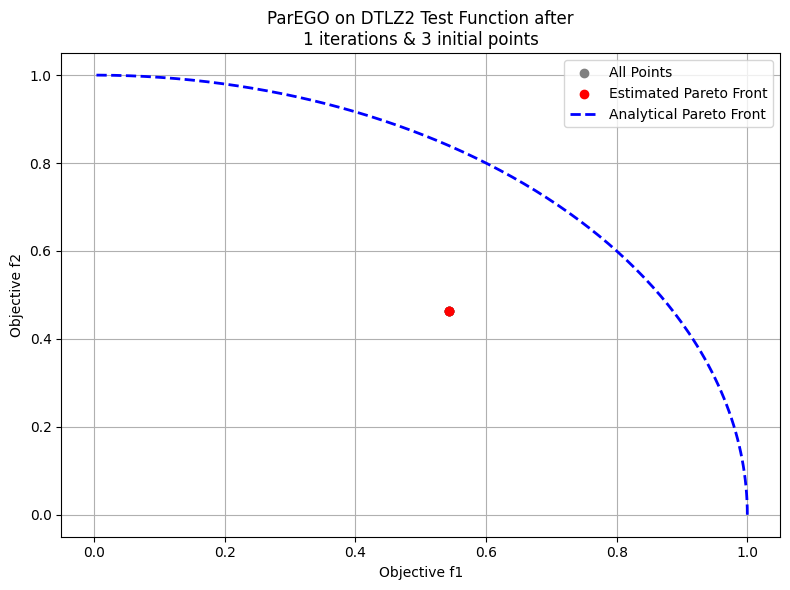

In [62]:
# --- Plot Results ---


# Generate analytical Pareto front for DTLZ2 (quarter circle from (1,0) to (0,1))
x0_vals = np.linspace(0, 1, 200)
pareto_f1_analytical = np.cos(0.5 * np.pi * x0_vals)
pareto_f2_analytical = np.sin(0.5 * np.pi * x0_vals)

plt.figure(figsize=(8, 6))

# Plot evaluated points and estimated Pareto front from your model
plt.scatter(all_f1, all_f2, c='gray', label="All Points")
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], c='red', label="Estimated Pareto Front")

# Plot analytical Pareto front curve
plt.plot(pareto_f1_analytical, pareto_f2_analytical, 'b--', linewidth=2, label="Analytical Pareto Front")

# Plot labels and styling
plt.xlabel("Objective f1")
plt.ylabel("Objective f2")
plt.title(f"ParEGO on DTLZ2 Test Function after\n{num_generations} iterations & {pop_size} initial points")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [64]:
# Prepare data to save
import json
results = {
    'final_population': population.tolist(),
    'final_pareto_front': pareto_front.tolist(),
    'all_evaluated_f1_points': all_f1.tolist(),
    'all_evaluated_f2_points': all_f2.tolist(),
}

# Save to a JSON file
json_filename = 'par_ego_results.json'
if True:
    with open(json_filename, 'w') as f:
        json.dump(results, f, indent=4)

